# 2015 Domestic flights delay data - Analysis and arrival delay prediction.
#### By: Swati Kohli

### Introduction
This notebook evaluates various attributes of a flight lifecycle (air journey from point A to B) and their effect towards the performance (on-time or delay). The data backed study is useful for both travellers and airlines to improve their decision process vis a vis flight time, expenses, marketing strategy etc. Linear regression method is used to investigate which parameters are related and to what extent they are influential contributors to the valuation of the delay.

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import NaN, nan

# Read the csv file
FlightData = pd.read_csv("flights.csv")
FlightData.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,EV,4160,N11150,JAX,EWR,540,...,743.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,1635,N025AA,ATL,DFW,625,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,WN,119,N271LV,RSW,ATL,800,...,934.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,EV,4936,N738EV,MSP,IAD,900,...,1240.0,12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,DL,2319,N960DL,LGA,MSP,1010,...,1225.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Part 1: Exploratory Analysis

Investigation of departure and arrival delay related features through exploratory analysis.

#### 1. About Features and Observations

In [2]:
print("Number of Observations(Rows) are: ",FlightData.shape[0])
print("Number of Features(Columns) are: ",FlightData.shape[1])


Number of Observations(Rows) are:  5821
Number of Features(Columns) are:  31


In [3]:
# Feature Names and about them
FlightData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 31 columns):
YEAR                   5821 non-null int64
MONTH                  5821 non-null int64
DAY                    5821 non-null int64
DAY_OF_WEEK            5821 non-null int64
AIRLINE                5821 non-null object
FLIGHT_NUMBER          5821 non-null int64
TAIL_NUMBER            5805 non-null object
ORIGIN_AIRPORT         5821 non-null object
DESTINATION_AIRPORT    5821 non-null object
SCHEDULED_DEPARTURE    5821 non-null int64
DEPARTURE_TIME         5730 non-null float64
DEPARTURE_DELAY        5730 non-null float64
TAXI_OUT               5728 non-null float64
WHEELS_OFF             5728 non-null float64
SCHEDULED_TIME         5821 non-null int64
ELAPSED_TIME           5713 non-null float64
AIR_TIME               5713 non-null float64
DISTANCE               5821 non-null int64
WHEELS_ON              5727 non-null float64
TAXI_IN                5727 non-null float64
SCHEDULED_ARR

#### 2. Different airlines and their counts

In [4]:
print ("Number of different Airlines:",FlightData['AIRLINE'].nunique() )
print ("Airline Count",FlightData['AIRLINE'].value_counts(), sep='\n')

Number of different Airlines: 14
Airline Count
WN    1285
DL     922
AA     722
OO     593
EV     563
UA     512
MQ     288
B6     263
US     212
AS     145
NK     119
F9      74
VX      66
HA      57
Name: AIRLINE, dtype: int64


The top three airlines are WN = Southwest, DL = Delta, AA = American Airlines.

#### 3. Any missing values in the departure delays and arrival delays? If yes, do they match? Potential reason(s) and removing these observations afterwards.

In [5]:
# sum of null values in departure delay 
Dep_Delay = FlightData['DEPARTURE_DELAY'].isnull().sum()
print("Missing values of Departure Delays are:",Dep_Delay)

# sum of null values in arrival delay 
Arvl_Delay=FlightData['ARRIVAL_DELAY'].isnull().sum()
print("Missing values of Arrival Delays are:",Arvl_Delay)

# check (boolean) if both numbers are same
print("Do they match?:", Arvl_Delay == Dep_Delay)

Missing values of Departure Delays are: 91
Missing values of Arrival Delays are: 108
Do they match?: False


There are 17 mismatches.

In [6]:
# find why observations don't match
FlightData[np.isnan(FlightData.ARRIVAL_DELAY)][['SCHEDULED_DEPARTURE','DEPARTURE_TIME','DEPARTURE_DELAY',
                                                'SCHEDULED_ARRIVAL','ARRIVAL_TIME','ARRIVAL_TIME']].head()


,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_TIME
1,625,NaN,NaN,755,NaN,NaN
10,1631,NaN,NaN,1815,NaN,NaN
47,1655,NaN,NaN,1748,NaN,NaN
115,1315,NaN,NaN,1450,NaN,NaN
116,1436,NaN,NaN,1535,NaN,NaN


In [7]:
Dep_time = FlightData['DEPARTURE_TIME'].isnull().sum()
print("Missing values of Departure time are:",Dep_time)

Arr_time = FlightData['ARRIVAL_TIME'].isnull().sum()
print("Missing values of Arrival time are:",Arr_time)


Missing values of Departure time are: 91
Missing values of Arrival time are: 94


Observation: Missing values dont match because:

Departure Delay and Arrival delay are calculated based on recorded actual time & scheduled time respectively, i.e. 
Departure Delay = Departure time - Scheduled Departure  

Since, data is not recorded for Departure time (91) & Arrival time (94), there are missing values for Departure Delay and Arrival delay.  

Remaining 14 records for arrival delay (108-94 = 14), have missing values which are not calculated even though there are records for Arrival time and Arrival Departure due to reasons that can be explored further. 

Exploring if diverted and canceled feature are reasons for these missing values.



In [8]:
print(FlightData.CANCELLED.sum())
print(FlightData.DIVERTED.sum())
print((FlightData.CANCELLED != FlightData.DIVERTED).sum()) #They add up to 108 cases, which is the total arrival delay. 

93
15
108


In [9]:
FlightData.loc[(FlightData.CANCELLED == 1) & (FlightData.DEPARTURE_DELAY.notnull())] 
# The two flights that are canceled but have departure delay value.

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2152,2015,5,18,1,UA,684,N810UA,ATL,EWR,1547,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
3766,2015,8,22,6,AA,593,N162UW,SNA,PHX,645,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN


This explains missing observations in the data. 93 flights are being canceled, so there is no departure delay, and 15 were diverted so there is no arrival record. However, there are still 2 flights that were canceled but have a departure delay. This could be because they took off but landed at the origin airport due to some technical difficulty.

In [10]:
# remove observations with nan for departure and arrival delay
FlightData.dropna(subset=['DEPARTURE_DELAY', 'ARRIVAL_DELAY'],inplace = True)
print("New number of Observations(Rows) removing missing values are: ",FlightData.shape[0])

New number of Observations(Rows) removing missing values are:  5713


#### 4. Observations through average and median departure and arrival delay

In [11]:
# data.mean() and data.median()
print('Average Departure delay is ',FlightData['DEPARTURE_DELAY'].mean(), 'and Median Departure delay is',FlightData['DEPARTURE_DELAY'].median())
print('Average Arrival delay is ',FlightData['ARRIVAL_DELAY'].mean(), 'and Median Arrival delay is',FlightData['ARRIVAL_DELAY'].median())


Average Departure delay is  8.886574479257833 and Median Departure delay is -2.0
Average Arrival delay is  3.9882723612812883 and Median Arrival delay is -5.0


Observation: 
Mean and median gives a centre of distribution of data and they are different for this dataset. It is observed that on an average departure delays are around 9 minutes. However, arrival delays on an average are less and almost 4 mintues. So there is little longer departure delay compared to arrival delays probably because airplane fly faster to make up for the delay.  

Also, median values reflect that flights actually depart and arrive early, approximately 2 & 5 minutes respectively. However, no conclusion can be drawn yet from mean or median values without diagnosis.

#### 5. Departure delays and arrival delays for each airline

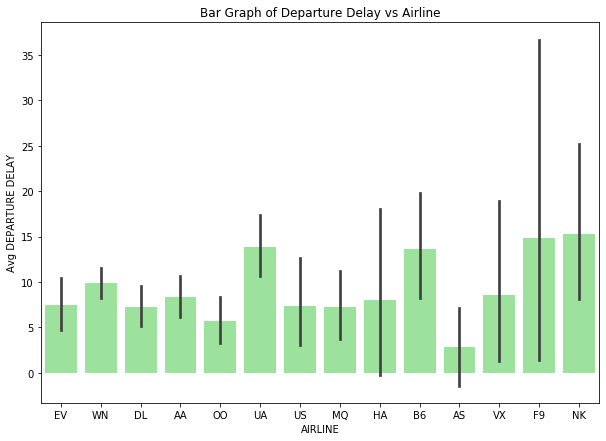

In [12]:
# Departure Delay vs Airline
fig = plt.figure(1, figsize=(10,7))
ax1 = sns.barplot(x="AIRLINE", y="DEPARTURE_DELAY", data=FlightData , color="lightgreen")
plt.xlabel("AIRLINE")
plt.ylabel("Avg DEPARTURE DELAY")
plt.title("Bar Graph of Departure Delay vs Airline")
plt.show()

Most airlines have minimal departure delays. NK (Spirit Air Lines) and F9 (Frontier Airlines) show more variability/some extreme values. 

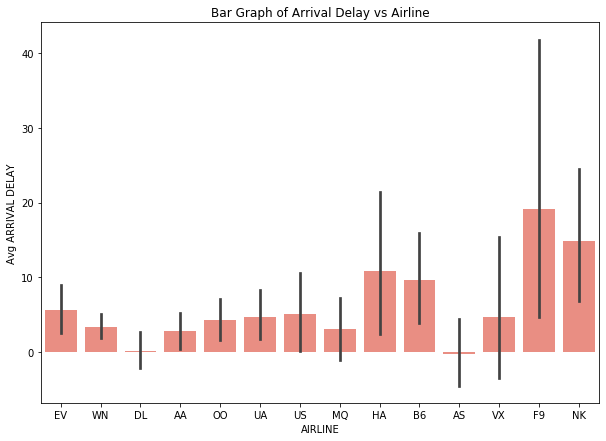

In [13]:
# Arrival Delay vs Airline
fig = plt.figure(1, figsize=(10,7))
ax2 = sns.barplot(x="AIRLINE", y="ARRIVAL_DELAY", data=FlightData, color="salmon" )
plt.xlabel("AIRLINE")
plt.ylabel("Avg ARRIVAL DELAY")
plt.title("Bar Graph of Arrival Delay vs Airline")
plt.show()

Arrival delay variability seems similar with few outliers. Again, Frontier Airlines has the most extreme arrival delay.

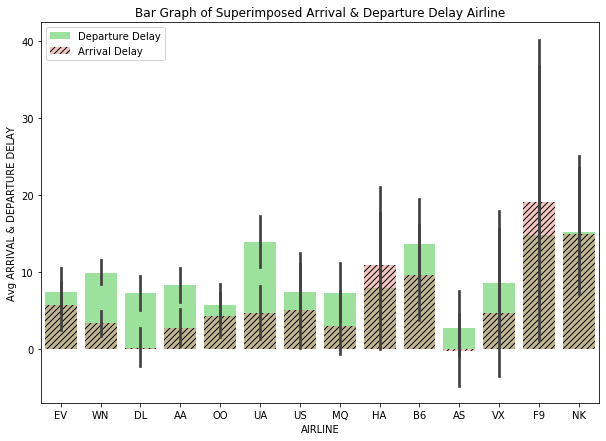

In [14]:
# superimposing both graphs to see difference
fig = plt.figure(1, figsize=(10,7))
labels = ['green','hatch']
ax3 = sns.barplot(y="DEPARTURE_DELAY", x="AIRLINE", data=FlightData, color="lightgreen", label = 'Departure Delay')
ax3 = sns.barplot(y="ARRIVAL_DELAY", x="AIRLINE", data=FlightData, color="salmon", hatch = '////',alpha = 0.5, label = 'Arrival Delay')


plt.xlabel("AIRLINE")
plt.ylabel("Avg ARRIVAL & DEPARTURE DELAY")
plt.title("Bar Graph of Superimposed Arrival & Departure Delay Airline")
plt.legend()
plt.show()

Observation: 
It is observed through superimposed graph that departure delays are higher than arrival delays. One can assume that airlines probably increase speed to minimize delays. 

#### 6.  5 number summary (min, Q1, median, Q3, max) of departure delay and arrival delay for each airline arranged by median delay (descending order). 

In [15]:
# describe to print 5 number summary
# descending order of median = 50%
Dep_Delay = FlightData.groupby('AIRLINE')['DEPARTURE_DELAY'].describe()[['max', '75%','50%','25%', 'min']]
print("Departure Delay",Dep_Delay.sort_values(by='50%',ascending=False), sep='\n')

Arvl_Delay = FlightData.groupby('AIRLINE')['ARRIVAL_DELAY'].describe()[['max', '75%','50%','25%', 'min']]
print("Arrival Delay",Arvl_Delay.sort_values(by='50%',ascending=False), sep='\n')


Departure Delay
           max    75%  50%  25%   min
AIRLINE                              
UA       332.0  14.00  1.5 -3.0 -12.0
WN       224.0  10.00  0.0 -3.0 -10.0
B6       330.0  11.00 -1.0 -5.0 -18.0
VX       230.0   3.25 -1.5 -4.0  -9.0
AA       289.0   7.00 -2.0 -5.0 -14.0
DL       419.0   3.00 -2.0 -4.0 -14.0
NK       353.0  20.00 -2.0 -6.0 -14.0
EV       382.0   4.00 -3.0 -6.0 -15.0
HA       202.0   1.00 -3.0 -6.0 -12.0
MQ       311.0   6.00 -3.0 -5.0 -13.0
OO       306.0   2.00 -3.0 -7.0 -23.0
US       345.0   2.75 -3.0 -5.0 -11.0
AS       186.0   2.00 -4.0 -8.0 -27.0
F9       650.0   4.00 -4.0 -7.0 -15.0
Arrival Delay
           max    75%  50%    25%   min
AIRLINE                                
F9       644.0  15.00  1.0  -9.00 -25.0
HA       194.0  10.00 -1.0  -5.00 -29.0
NK       354.0  23.00 -2.0 -10.75 -36.0
OO       304.0   8.00 -3.0 -12.00 -42.0
EV       386.0   8.00 -4.0 -12.00 -36.0
US       334.0  11.00 -4.0 -13.00 -42.0
WN       273.0   8.00 -4.0 -12.00 -53.0
B6

#### 7. Top 10 airports with most averaged departure delay and analysis of top airport for potential reason

In [16]:
Avg_dep_delay = FlightData.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].mean().sort_values(ascending=False)
print(Avg_dep_delay.head(10))

ORIGIN_AIRPORT
FAR      161.000000
12898    119.000000
BMI      101.333333
ERI       92.000000
14696     88.000000
MYR       88.000000
14576     88.000000
10157     87.500000
12992     80.000000
12206     67.500000
Name: DEPARTURE_DELAY, dtype: float64


In [17]:
# find cause of top airport by count of various delay reasons at FAR
FlightData[(FlightData['ORIGIN_AIRPORT']=='FAR')|(FlightData['ORIGIN_AIRPORT']=='12898')][['DEPARTURE_DELAY',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY','AIR_TIME', 'DISTANCE']]

,DEPARTURE_DELAY,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIR_TIME,DISTANCE
2991,161.0,175.0,0,0,NaN,100.0,0.0,0.0,75.0,0.0,88.0,557
4898,119.0,111.0,0,0,NaN,111.0,0.0,0.0,0.0,0.0,83.0,459


Observation: 'FAR' origin airport (Hector International Airport at North Dakota) has highest average departure delay.Diving deeper shows there is only one observation for this airport with departure delay of 175 min and arrival delay of 161 min. The flight was not diverted or cancelled but the flight was delayed due to air system delay of 100 min and aircraft delay of 75 min.

#### 8. Intuitive analysis - Study if the departure/arrival delay is influenced by distance of trip. 

In [18]:
Distance_corr = FlightData[['DISTANCE', 'DEPARTURE_DELAY','ARRIVAL_DELAY']]
Distance_corr.corr()

,DISTANCE,DEPARTURE_DELAY,ARRIVAL_DELAY
DISTANCE,1.000000,0.023095,-0.027935
DEPARTURE_DELAY,0.023095,1.000000,0.936069
ARRIVAL_DELAY,-0.027935,0.936069,1.000000


Observation: Correlation matrix shows a very low correlation of distance with both departure and arrival delays.

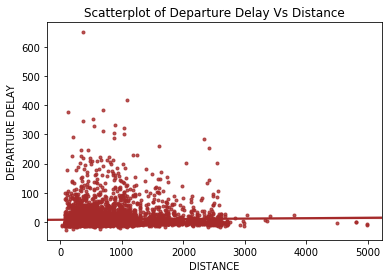

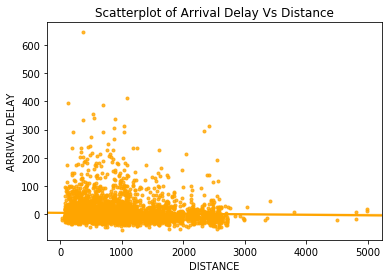

In [19]:
# scatter plot with regression line

scatter, ax = plt.subplots()
ax = sns.regplot(x = 'DISTANCE', y = 'DEPARTURE_DELAY', data = FlightData, color = "brown",marker = '.' )

ax.set_title('Scatterplot of Departure Delay Vs Distance')
ax.set_xlabel('DISTANCE')
ax.set_ylabel('DEPARTURE DELAY')

plt.show()

# scatter plot with regression line
scatter, ax = plt.subplots()
ax = sns.regplot(x = 'DISTANCE', y = 'ARRIVAL_DELAY', data = FlightData, color = "orange", marker = '.')

ax.set_title('Scatterplot of Arrival Delay Vs Distance')
ax.set_xlabel('DISTANCE')
ax.set_ylabel('ARRIVAL DELAY')

plt.show()

Observation: With further diagnosis, scatter plot shows no particular pattern or trend of distance with departure or arrival delay. If we plot a regression line, it is almost parallel to X axis which implies predictor Distance has no implication on Departure or Arrival Delay. The same is seen in correlation matrix.


#### 9. Intuitive analysis - Day of week vs departure delay

In [20]:
Week_corr= FlightData[['DAY_OF_WEEK', 'DEPARTURE_DELAY','ARRIVAL_DELAY']]
Week_corr.corr()

,DAY_OF_WEEK,DEPARTURE_DELAY,ARRIVAL_DELAY
DAY_OF_WEEK,1.000000,-0.004786,-0.008692
DEPARTURE_DELAY,-0.004786,1.000000,0.936069
ARRIVAL_DELAY,-0.008692,0.936069,1.000000


,count,mean,std,min,25%,50%,75%,max
DAY_OF_WEEK,,,,,,,,
1,835.0,9.786826,35.869736,-17.0,-5.0,-2.0,8.0,382.0
2,801.0,8.995006,33.902581,-18.0,-5.0,-2.0,6.0,330.0
3,816.0,7.488971,30.602255,-16.0,-5.0,-2.0,6.0,345.0
4,858.0,9.390443,34.996486,-18.0,-4.0,-1.0,8.0,419.0
5,906.0,9.661148,32.661177,-16.0,-4.0,-1.0,8.0,311.0
6,699.0,7.125894,32.828087,-27.0,-5.0,-2.0,5.0,353.0
7,798.0,9.385965,38.104675,-23.0,-5.0,-1.0,9.0,650.0


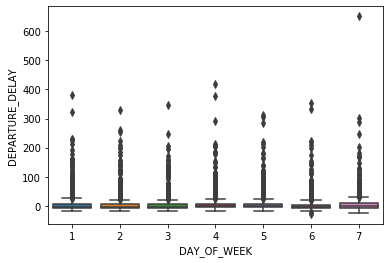

In [21]:
sns.boxplot(x = 'DAY_OF_WEEK', y = 'DEPARTURE_DELAY', data = FlightData)
FlightData.groupby('DAY_OF_WEEK').describe()['DEPARTURE_DELAY']

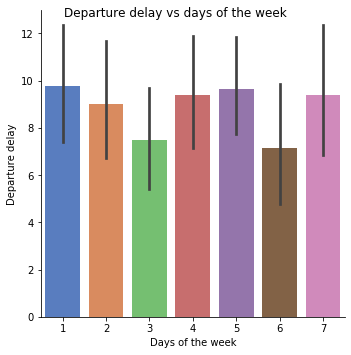

In [22]:
# Graph showing variation in departure delay as per day of the week.
ax = sns.catplot(x = 'DAY_OF_WEEK', y = 'DEPARTURE_DELAY', data = FlightData , kind = "bar", palette = "muted")

ax.set_xlabels('Days of the week')
ax.set_ylabels('Departure delay')

ax.fig.suptitle('Departure delay vs days of the week')

plt.show()


Observation: 
Numerical summary shows Wednesdays and Saturdays have a lower average departure delay, while the rest of the week is quite consistent.
Boxplot shows no particular trend because of outliers, therefore, departure delays does not have any relation with the days of the week. It is also seen in the correlation matrix where the value is extremely low (-0.004) between the two. 

#### 10. Exploring if there is a departure delay (i.e. positive values for departure delay), does distance have anything to do with arrival delay? Presuming longer distance flights can make up more time.

In [23]:
# Create dataframe with positive departure delays only
FD_dep_delay= FlightData[FlightData['DEPARTURE_DELAY']>0][['AIRLINE','DISTANCE','DEPARTURE_DELAY','ARRIVAL_DELAY']]

# check correlation
FD_dep_delay.corr()

,DISTANCE,DEPARTURE_DELAY,ARRIVAL_DELAY
DISTANCE,1.000000,-0.044285,-0.094924
DEPARTURE_DELAY,-0.044285,1.000000,0.960662
ARRIVAL_DELAY,-0.094924,0.960662,1.000000


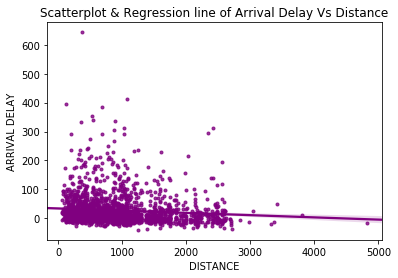

In [24]:
# scatter plot with regression line
scatter, ax = plt.subplots()
ax = sns.regplot(x = 'DISTANCE', y = 'ARRIVAL_DELAY', data = FD_dep_delay, color = "purple",marker = '.')

ax.set_title('Scatterplot & Regression line of Arrival Delay Vs Distance')
ax.set_xlabel('DISTANCE')
ax.set_ylabel('ARRIVAL DELAY')

plt.show()

Observation: Graph still shows arrival delays does not have any relation with distance. It is also seen in the correlation matrix where the value is extremely low (-0.09) between the two. 

#### 11. Analyse Departure delays. 
How many flights overall were delayed in 2015? From those delayed, how are the Departure delay thresholds (15 minutes, 1 hour, more than one hour) distributed overall and for each airlines? For example, are more airlines delayed under 15 minutes or more than an hour?

In [25]:
# Approach
# Part 1: Piechart to see the percentage of overall on-time & delayed flights
# Part 2: Bargraph to see the various levels of delay (short, medium & high) for every airline.
# Part 3: Piechart to summarize the observation of bar graph above to overall percentage.

# Part 1
# create a column to find how many flights out of the total are on-time and delayed.
FlightData['Dep_Delay_Overall'] = 'On_Schedule'
FlightData.loc[(FlightData.DEPARTURE_DELAY > 0),'Dep_Delay_Overall'] = 'Delayed'
print (FlightData.head(3))


# Count type and frequency
Overall_Delay_chart= FlightData['Dep_Delay_Overall'].value_counts()
Overall_Delay_chartds= pd.Series(Overall_Delay_chart) # Dataseries for value counts of unique dummy values
print ("Unique values are:",Overall_Delay_chartds, sep='\n')

Schedule_Type=FlightData['Dep_Delay_Overall'].unique() #for Label

   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      EV           4160      N11150   
2  2015      1    1            4      WN            119      N271LV   
3  2015      1    1            4      EV           4936      N738EV   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_DELAY  \
0            JAX                 EWR                  540  ...          -14.0   
2            RSW                 ATL                  800  ...          -11.0   
3            MSP                 IAD                  900  ...           12.0   

   DIVERTED  CANCELLED  CANCELLATION_REASON  AIR_SYSTEM_DELAY  SECURITY_DELAY  \
0         0          0                  NaN               NaN             NaN   
2         0          0                  NaN               NaN             NaN   
3         0          0                  NaN               NaN             NaN   

   AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  Dep_Delay_O

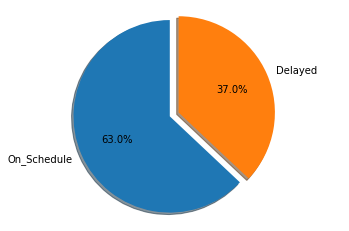

In [26]:
# Piechart for on-time & delay percentage
fig1,ax1= plt.subplots()
explode = (0.1, 0)
ax1.pie(Overall_Delay_chartds, labels=Schedule_Type, autopct='%.1f%%', startangle=90, shadow = True, explode = explode)
ax1.axis('equal')

plt.show()

**Observation: Pie Chart shows 37% flights delayed.**

In [27]:
# Part 2

# Further, Level of delays are added as dummy variables to see for each airline
# To the positive delayed flights from Q10, add time based delays. Categories are as below:
# short: 1-15 minutes
# Medium: 16-60 minutes
# High: above 60 minutes

# create dummy column for delay levels
FD_dep_delay['Delay_lvl'] = 'Short'
FD_dep_delay.loc[(FD_dep_delay.DEPARTURE_DELAY >=15)&(FD_dep_delay.DEPARTURE_DELAY <=60),'Delay_lvl']='Medium'
FD_dep_delay.loc[(FD_dep_delay.DEPARTURE_DELAY >=60),'Delay_lvl']='High'
FD_dep_delay.head()

,AIRLINE,DISTANCE,DEPARTURE_DELAY,ARRIVAL_DELAY,Delay_lvl
3,EV,908,1.0,12.0,Short
7,OO,222,32.0,36.0,Medium
12,US,1916,13.0,7.0,Short
14,UA,1874,12.0,-18.0,Short
15,WN,317,6.0,0.0,Short


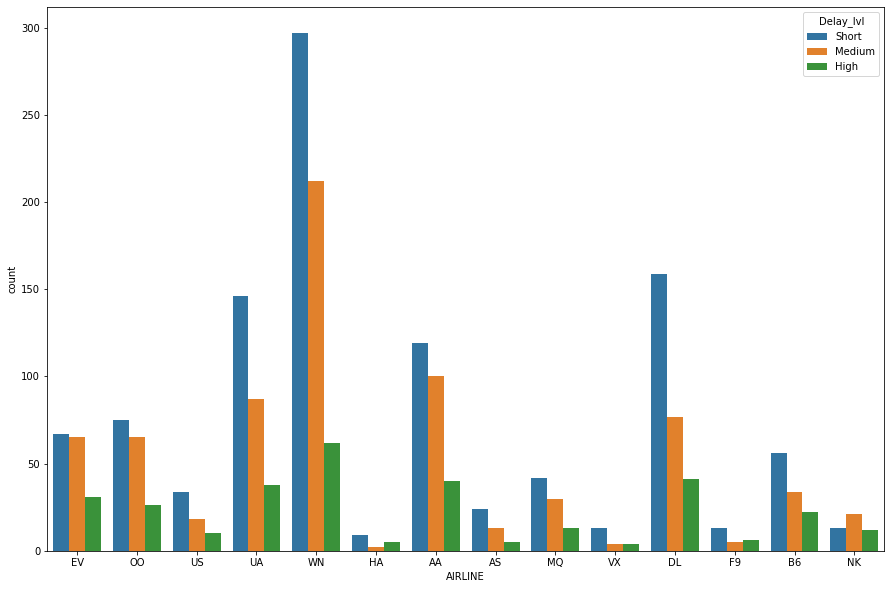

In [28]:
# Graph showing distribution of delay levels for each airline
fig = plt.figure(1, figsize=(15,10))
ax = sns.countplot(x="AIRLINE", hue='Delay_lvl', data=FD_dep_delay)

Observation: Graph shows most short delays, i.e. from 1 to 15 minutes for airlines. Also, longer than one hour delays are least. **Further, at first glance, predominantly, trend is high delays (longer than 1 hour) are one-third of the short delays.**  
Let's check the individual percentage of overall delay levels to see if our observation is correct.

In [29]:
# Part 3
# Overall percentage of delay levels

# Count type and frequency
Lvl_Delay_chart= FD_dep_delay['Delay_lvl'].value_counts()

Lvl_Delay_chartds= pd.Series(Lvl_Delay_chart) # Dataseries for value counts of unique dummy values
print ("Unique values are:", Lvl_Delay_chartds, sep='\n')

Lvl_Type = FD_dep_delay['Delay_lvl'].unique() # For Label

Unique values are:
Short     1067
Medium     733
High       315
Name: Delay_lvl, dtype: int64


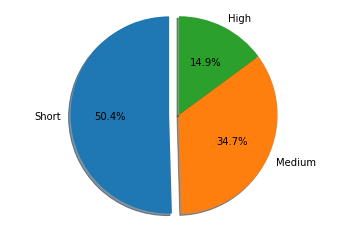

In [30]:
# Piechart of delay level percentage 
fig2,ax2= plt.subplots()
explode = (0.1, 0,0)
ax2.pie(Lvl_Delay_chartds, labels=Lvl_Type, autopct='%.1f%%', startangle=90, shadow = True, explode = explode)
ax2.axis('equal')

plt.show()

**Observation: Pie Chart shows 50% of the flights delayed are under 15 minutes.** Also, 15% of the flights are departure delays of more than an hour.  
Trend as seen in the bar graph was high delays are one third of short delays which is also seen in the pie chart.

#### 12. Exploring if there a specific time (or time period) in the day when flight departures are usually delayed or are usually on time.

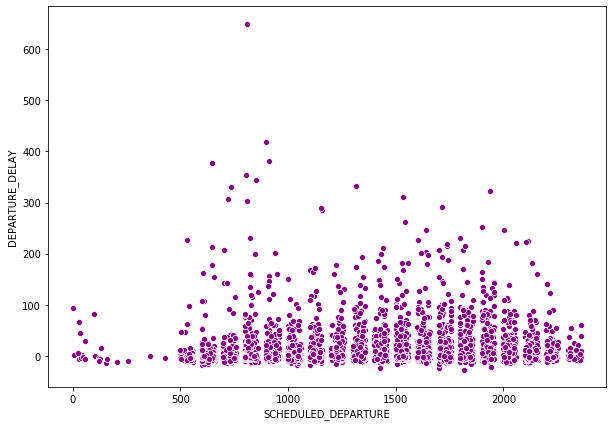

In [31]:
# Part 1: Scatter plot to diagnose a trend (if any)
# Part 2: Bar graph to see if trend shows any insight as per time slot of the day (morning, daytime, evening & late/early hours)

# Part 1
# Hourly scatter plot 
fig = plt.figure(1, figsize=(10,7))
ax = sns.scatterplot(x="SCHEDULED_DEPARTURE", y="DEPARTURE_DELAY", data=FlightData, color = "purple",marker = 'o')


Observation: Graph shows minimal delays particulary around 12am to 5am. Lets analyse time period wise

In [32]:
# Part 2
# further analysis by time period
# Morning :         6am to 12pm
# Daytime:          12pm to 6pm
# Evening :         6pm to 12pm
# Late/Early hours: 12pm to 6am

# creating parts of the day and adding to dataframe
FlightData['Time_Dummy'] = 'Late/Early_Hours'
FlightData.loc[(FlightData.SCHEDULED_DEPARTURE > 600) & (FlightData.SCHEDULED_DEPARTURE <= 1200),'Time_Dummy'] = 'Morning'
FlightData.loc[(FlightData.SCHEDULED_DEPARTURE > 1200) & (FlightData.SCHEDULED_DEPARTURE <= 1800),'Time_Dummy'] = 'Daytime'
FlightData.loc[(FlightData.SCHEDULED_DEPARTURE > 1800) & (FlightData.SCHEDULED_DEPARTURE <= 2400),'Time_Dummy'] = 'Evening'
FlightData.loc[FlightData.SCHEDULED_DEPARTURE > 2400,'Time_Dummy'] = 'Late/Early_Hours'

FlightData.head(6)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,Dep_Delay_Overall,Time_Dummy
0,2015,1,1,4,EV,4160,N11150,JAX,EWR,540,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,On_Schedule,Late/Early_Hours
2,2015,1,1,4,WN,119,N271LV,RSW,ATL,800,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,On_Schedule,Morning
3,2015,1,1,4,EV,4936,N738EV,MSP,IAD,900,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Delayed,Morning
4,2015,1,1,4,DL,2319,N960DL,LGA,MSP,1010,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,On_Schedule,Morning
5,2015,1,1,4,DL,1806,N594NW,LAX,DTW,1115,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,On_Schedule,Morning
6,2015,1,1,4,AA,1509,N3BGAA,BWI,MIA,1309,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,On_Schedule,Daytime


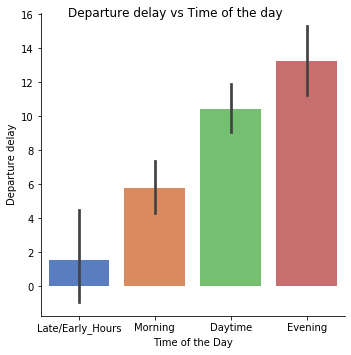

In [33]:
# graph of Departure delays vs Time period
ax = sns.catplot(x = 'Time_Dummy', y = 'DEPARTURE_DELAY', data = FlightData , kind = "bar", palette = "muted")

ax.set_xlabels('Time of the Day')
ax.set_ylabels('Departure delay')
ax.fig.suptitle('Departure delay vs Time of the day')

plt.show()


Observation: Graph shows an interesting pattern- a progressive delay with time of the day. We observe least delay from 12pm to 6am and most delays during evening.

### Part II: Regression Analysis
#### SubPart 1
1. Response variable ARRIVAL DELAY. 
2. Remove all the missing data in the WEATHER DELAY column. so no more missing values in the data set (except for the cancellation reason feature).

In [34]:
# remove records with null value in WEATHER DELAY
flights_new = FlightData.dropna(axis=0,subset=['WEATHER_DELAY'])

In [35]:
# check null data in new dataframe. Only CANCELLATION_REASON field has 1072 null values.
#
numrow=flights_new.shape[0]
missing = numrow - flights_new.count()
print(missing)

YEAR                      0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
FLIGHT_NUMBER             0
TAIL_NUMBER               0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
SCHEDULED_DEPARTURE       0
DEPARTURE_TIME            0
DEPARTURE_DELAY           0
TAXI_OUT                  0
WHEELS_OFF                0
SCHEDULED_TIME            0
ELAPSED_TIME              0
AIR_TIME                  0
DISTANCE                  0
WHEELS_ON                 0
TAXI_IN                   0
SCHEDULED_ARRIVAL         0
ARRIVAL_TIME              0
ARRIVAL_DELAY             0
DIVERTED                  0
CANCELLED                 0
CANCELLATION_REASON    1072
AIR_SYSTEM_DELAY          0
SECURITY_DELAY            0
AIRLINE_DELAY             0
LATE_AIRCRAFT_DELAY       0
WEATHER_DELAY             0
Dep_Delay_Overall         0
Time_Dummy                0
dtype: int64


#### 2. Build a regression model 
Using all the observations, and the following predictors:[LATE AIRCRAFT DELAY, AIRLINE DELAY, AIR SYSTEM DELAY, WEATHER DELAY, DAY OF WEEK, DEPARTURE TIME, DEPARTURE DELAY, DISTANCE, AIRLINE] a total of 9 predictors. Notice the AIRLINE variable is a categorical variable.

In [36]:
# create dummy varibles for Airline categorical variable

airline_dummy =pd.get_dummies(flights_new['AIRLINE'])        # create dummy varibles for AIRLINE
flights_new =pd.concat([flights_new, airline_dummy], axis=1) # concatenate dummay variable with flights_new dataset
del flights_new['AA']   

In [37]:
flights_new.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'Dep_Delay_Overall',
       'Time_Dummy', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO',
       'UA', 'US', 'VX', 'WN'],
      dtype='object')

In [38]:
import statsmodels.api as sm
X = flights_new[['LATE_AIRCRAFT_DELAY', 'AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'WEATHER_DELAY', 'DAY_OF_WEEK', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'DISTANCE','AS', 'B6', 'DL', 'EV', 'F9',
       'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX', 'WN']]
y=flights_new['ARRIVAL_DELAY']
X_int = sm.add_constant(X)
linreg1 = sm.OLS(y, X_int).fit()
linreg1.summary()

C:\Users\Swati\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.292e+04
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        15:47:08   Log-Likelihood:                -2143.1
No. Observations:                1072   AIC:                             4330.
Df Residuals:                    1050   BIC:                             4440.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.5515      0.287      1.920      0.055      -0.012       1.115
LATE_AIRCRAFT_DELAY     0.9812      0.004    251.863      0.000       0.974       0.989
AIRLINE_DELAY           0.9819      0.004    258.890      0.000       0.974       0.989
AIR_SYSTEM_DELAY        0.9851      0.003    312.534      0.000       0.979       0.991
WEATHER_DELAY           0.9842      0.004    239.704      0.000       0.976       0.992
DAY_OF_WEEK            -0.0320      0.028     -1.127      0.260      -0.088       0.024
DEPARTURE_TIME         -0.0001      0.000     -0.909      0.364      -0.000       0.000
DEPARTURE_DELAY         0.0160      0.003      4.697      0.000       0.009       0.023
DISTANCE                0.0001      0.000      1.078      0.281   -9.01e-05       0.000
AS                      1.8508      0.432      4.282      0.000       1.003       2.699
B6                     -0.0082      0.276     -0.030      0.976      -0.549       0.533
DL                     -0.2441      0.224     -1.090      0.276      -0.683       0.195
EV                     -0.1395      0.241     -0.579      0.563      -0.612       0.333
F9                     -0.0320      0.444     -0.072      0.943      -0.904       0.840
HA                     -0.1580      0.547     -0.289      0.773      -1.230       0.914
MQ                     -0.1346      0.294     -0.457      0.648      -0.712       0.443
NK                      0.4646      0.331      1.402      0.161      -0.186       1.115
OO                     -0.1250      0.240     -0.520      0.603      -0.596       0.346
UA                     -0.3681      0.233     -1.581      0.114      -0.825       0.089
US                     -0.1911      0.319     -0.600      0.549      -0.816       0.434
VX                     -0.0841      0.544     -0.155      0.877      -1.152       0.984
WN                     -0.1901      0.198     -0.959      0.338      -0.579       0.199
==============================================================================
Omnibus:                     2222.999   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4344520.011
Skew:                          16.618   Prob(JB):                         0.00
Kurtosis:                     313.098   Cond. No.                     2.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 3. Model diagnostics and observations

Observation: DAY_OF_WEEK, DEPARTURE_TIME, DISTANCE, AIRLINE (except AS) have p-value higher than 0.05 which makes them insignificant for prediction of ARRIVAL DELAY.

from the model diagnosis, LATE_AIRCRAFT_DELAY, AIRLINE_DELAY, AIR_SYSTEM_DELAY, WEATHER_DELAY, DEPARTURE_DELAY and AS variables have p-value less than 0.05 which make them seem significant for the regression model. 

#### 4. Interpretations for a few of of the coefficients

When LATE_AIRCRAFT_DELAY is 1 minute keeping all other variables constant, then flight will be delayed by 0.98 minutes.  

When DEPARTURE_DELAY is of 1 minute, keeping all other variables constant, we can predict that arrival delay will be -0.0001 seconds, in other words if departure delay is of 1 minute then arrival time wil be preponed by few microseconds.  

When day of week increases by 1, then arrival delay decreases by 0.03 min, which does not make sense since it is a categorical variable which is not converted.


Coefficients reveal that the four types of delays have similar contribution to the arrival delay. 
Closer look at the data set shows most of these delays have value 0, meaning that in most cases they don't play a role in estimating arrival delay.  
The remaining numerical varibles are almost all nonsignificant except for departure delay.  

Focusing on the sign of the coefficients, it shows that the earlier the flight is, the less arrival delay there is, which aligs with reality, as early flights are usually on time, while flights later in the day suffers from the delays stacked up from before. One interesting observation though, is that distance has a positive effect on arrival delay.

Text(0.5, 1.0, 'Residuls vs Fitted values')

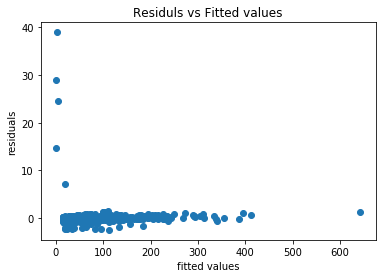

In [39]:
plt.scatter(linreg1.fittedvalues, linreg1.resid)
#plt.ylim(-1, 1)
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.title('Residuls vs Fitted values')

Observation: the residual vs fitted values plot shows that error terms does not follow homoskedasticity assumption of linearity.

Text(0.5, 1.0, 'qq plot')

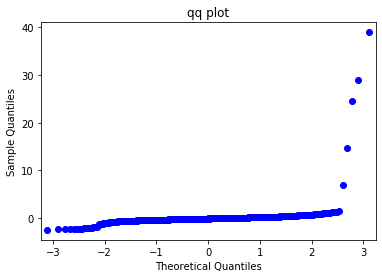

In [40]:
fig=sm.qqplot(linreg1.resid)
plt.title('qq plot')

(-3, 3)

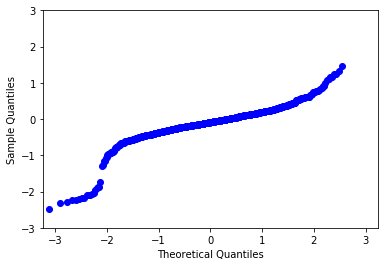

In [41]:
# Zooming in y axis of the sctterplot graph by considering residual values between 03 to 3
fig=sm.qqplot(linreg1.resid)
plt.ylim(-3,3)

Observation: 
Firstly, there are quite a few outliers in the data set which are affecting the visualization. Removing outliers will reveal how good the model fit is.
Slight curvature pattern in the residual plot, indicates the violation of linearity. 
The  𝑟2  is very high showing goodness-of-fit but that's not enough to say the model is suitable.

# Subpart 2

#### 1. Removing outliers using the boxplot method in the ARRIVAL DELAY variable.

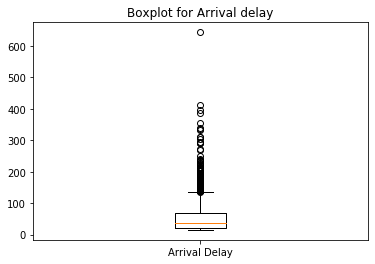

In [42]:
# boxplot of Arrival delay
#
plt.boxplot([flights_new.ARRIVAL_DELAY])
plt.xticks([1],['Arrival Delay'])
plt.title('Boxplot for Arrival delay')
plt.show()

In [43]:
# calculate IQR of arrival delay
IQR = flights_new.ARRIVAL_DELAY.quantile(0.75) - flights_new.ARRIVAL_DELAY.quantile(0.25)
print(IQR)

45.25


In [44]:
# drop outlier record from arrival delay dependent variable. 
# After removing outlier record, a new dataframe is created in order to run code multiple time for diagnosis
#
flights_clean = flights_new.drop(flights_new[flights_new['ARRIVAL_DELAY']> (flights_new.ARRIVAL_DELAY.quantile(0.75) + 1.5* IQR)].index)

In [45]:
# nbr of records in dataset after removing outliers
flights_clean.shape[0]

986

#### 2. Refit the linear regression model. 
Apply transformation as log(ARRIVAL DELAY) as the response. 
Also, remove the nonsignificant predictors from the previous model (with p-values larger than 0.05) and the AIRLINE variable. When removing nonsignificant predictors one can only eliminate one variable per step, but for now we will ignore this rule and remove everything in one step.

In [46]:
y_log = np.log(flights_clean.ARRIVAL_DELAY)

In [47]:
# fit regression model with statsmodels library to predict log value of arrival delay
#
X = flights_clean[['LATE_AIRCRAFT_DELAY', 'AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'WEATHER_DELAY', 'DEPARTURE_DELAY']]
X_int = sm.add_constant(X)
linreg3 = sm.OLS(y_log, X_int).fit()
print(linreg3.summary())

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     2161.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        15:47:09   Log-Likelihood:                 343.09
No. Observations:                 986   AIC:                            -674.2
Df Residuals:                     980   BIC:                            -644.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.7076    

C:\Users\Swati\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0.5, 1.0, 'residuals vs fitted values(log scale)')

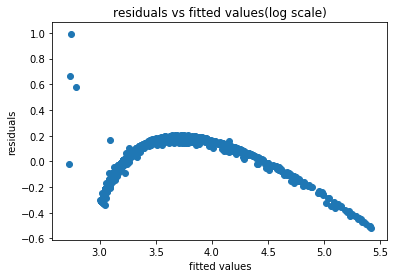

In [48]:
plt.scatter(linreg3.fittedvalues, linreg3.resid)
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.title('residuals vs fitted values(log scale)')

Text(0.5, 1.0, 'qq plot')

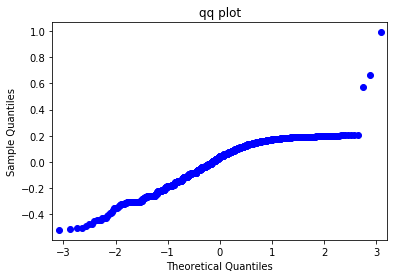

In [49]:
fig = sm.qqplot(linreg3.resid)
plt.title('qq plot')

#### 3. Model diagnostics to investigate improvement

With response variable transformed to log scale, there is improvement in qq plot which shows normality of error terms. Still it is not enough to conclude normality assumption of linearity. In fact, we can see there is a strong nonlinear relationship between the inputs and output, as the residual plot shows a curvature pattern.  

R-square value reduced to 0.917 (as compared to 0.99 in previous model), this is because reduction in number of predictor variables. F-statistics is also reduced as compared to previous model.
Skew is reduced to -0.367 from 16.618


In [50]:
# Calculate predicted y (yhat) and convert it from log scale to normal scale
#
yhat = linreg3.predict(X_int)
predicted_y = np.exp(yhat)

Text(0.5, 1.0, 'residuals vs fitted values)')

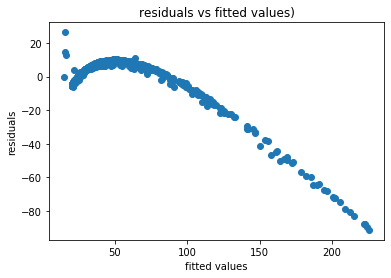

In [51]:
# sctterplot of residuals vs fitted values on normal scale
#
plt.scatter(predicted_y, flights_clean.ARRIVAL_DELAY - predicted_y)
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.title('residuals vs fitted values)')

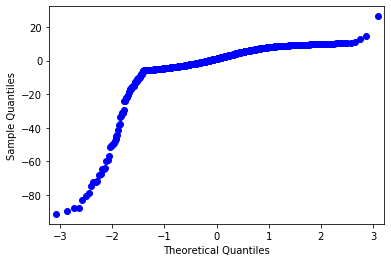

In [52]:
fig = sm.qqplot(flights_clean.ARRIVAL_DELAY - predicted_y)

#### 4. Suggestions to further improve the model fit.

1. To improve model further, stepwise regression should be done to add or remove variables from the model. Adding interaction terms to the model could be explored as well.

2. Also from the data vizualisation we have seen that arrival delay has some pattern with time of day. It can be included as categorical variable in model to check if the model performance improve further. 

3. Day of week variable is an ordinal variable hence it should be converted to categorical varaible and its dummy variable can be added in model to study the effect of new variable in model further. 

4. Indicator variables Cancelled and Diverted should also be used to check their impact on arrival delay.

5. As described above, the graph shows nonlinearity between inputs and output. One might consider transforming some of the input variables (to polynomial terms) to solve this issue. For instance, adding a squared term might result in a better looking residual graph. As for the variables with too many zeros, there are several ad-hoc approaches one can take. For example, convert the variable into categorical variables, or perform some special transformations, or even use different models.